In [ ]:
import numpy as np
import pandas as pd
import json
import tqdm
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import PredefinedSplit
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_absolute_error as mae, mean_squared_log_error as msle, make_scorer
tqdm.tqdm.pandas()
from dateutil.relativedelta import *
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# warnings.filterwarnings('BokehDeprecationWarning')

In [ ]:
from plotting import plot_ts
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
start_date = '2017-01-09'
end_date = '2021-03-31'

# Модуль выявления разладок


In [ ]:
class AnomalyDetector(object):
    """
    Класс для детектирования аномалий методом CUSUM

    Параметры
    ----------
    backward_window_size : integer, optional, default 30
        Размер временного окна для оценки статистик

    forward_window_size : integer, optional, default 14
        Размер временнего окна для сравнения с backward_window_size

    threshold : float, optional, default 5.0
        Порог

    drift : float, optional, default 1.0
        Отклонение от среднего

    anomalies: pd.Series
        последовательность нулей и единиц(с сохранением последовательности индексов изначально временного ряда), 1 - аномалия, 0 - не аномалия

    """

    def __init__(self, backward_window_size=30, forward_window_size=14,
                 threshold=5.0, drift=1.0):
        self.backward_window_size = backward_window_size
        self.forward_window_size = forward_window_size
        self.threshold = threshold
        self.drift = drift
        self.anomalies_ = None


    def one_pass(self, train_zone, prediction_zone, threshold=None, drift=None):
        """
        Функция для обнаружения аномалий за один проход

        Параметры
        ----------
        train_zone : pandas.Series or pandas.DataFrame
            Обучающая выборка для подсчета нужных статистик

        prediction_zone : pandas.Series or pandas.DataFrame
            Тестовая выборка для обнаружения аномалий

        threshold : float, optional, default 5.0
            Порог

        drift : float, optional, default 1.0
            Смещение

        Возвращает
        -------
        is_fault : numpy array
            Является аномалией или нет
        """

        if not threshold:
            threshold = self.threshold
        if not drift:
            drift = self.drift

        current_std = np.nanstd(train_zone, ddof=1)
        current_mean = np.nanmean(train_zone)
        drift = drift * current_std
        threshold = threshold * current_std

        x = prediction_zone.astype('float64')
        gp, gn = np.zeros(x.size), np.zeros(x.size)

        for i in range(1, x.size):
            gp[i] = max(gp[i-1] + x[i] - current_mean - drift, 0)
            gn[i] = min(gn[i-1] + x[i] - current_mean + drift, 0)

        is_fault = np.logical_or(gp > threshold, gn < -threshold)
        return is_fault

    def detect(self, time_series, threshold=None, drift=None, excluded_points=None):
        """
        Функция для обнаружения аномалий в скользящем окне

        Параметры
        ----------
        time_series : pandas.Series
            Временной ряд

        threshold : float, optional, default 5.0
            Порог

        drift : float, optional, default 1.0
            Смещение

        excluded_points : pandas.Series.index
            Точки, которые будем исключать

        Возвращает
        -------
        self.anomalies_ : pandas.Series, shape = [len(time_series)]
            последовательность нулей и единиц, 1 - аномалия, 0 - не аномалия

        """
        if excluded_points is not None:
            time_series[time_series.index.isin(excluded_points)] = np.nan

        ts_values = time_series.values
        ts_index = time_series.index

        detection_series = np.zeros(len(ts_values)).astype('int32')

        for ini_index in range(len(ts_values) - (self.backward_window_size + self.forward_window_size)):
            sep_index = ini_index + self.backward_window_size
            end_index = sep_index + self.forward_window_size
            faults_indexes = self.one_pass(ts_values[ini_index:sep_index],
                                           ts_values[sep_index:end_index],
                                           threshold, drift)
            detection_series[sep_index:end_index][faults_indexes] = 1
        self.anomalies_ = pd.Series(detection_series, index=ts_index)

        return self.anomalies_

# Модуль отбора признаков


In [ ]:
def make_features(time_series,
                  calendar_features=None,
                  is_mean_month=True,
                  window_weekdays=3,
                  window_days=7,
                  lags=range(1, 5),
                  usd_course_feature=None):
    """
    Модуль для генерации признаков

    Параметры
    ----------
    time_series : pandas.Series
        Временной ряд
    calendar_features : pandas.DataFrame
        Набор календарных фичей

    is_mean_month : bool, default True
        Считаем ли среднее по месяцу

    window_weekdays : integer, default 3
        Размер недельного временнего окна

    window_days : integer, default 7
        Размер дневного временнего окна

    lags : range, default (1, 5)
        Размер лагов

    usd_course_feature : pandas.Series
        Курс рубль-доллар

    Возвращает
    -------
    data: pd.DataFrame
        Датафрейм с признаками
    """
    data = pd.DataFrame(time_series).copy()
    data.columns = ['y']


    # лаги
    if lags is not None:
        for i in lags:
            data['lag_{}'.format(i)] = data.y.shift(i)
        m_lag_1 = []
        m_lag0 = []
        m_lag1 = []
        for i in range(data.shape[0]):
            date_1 = data.iloc[i].name - relativedelta(months=1) - relativedelta(days=1)
            if date_1 in data.index:
                m_lag_1.append(data.loc[date_1, 'y'])
            else:
                m_lag_1.append(np.nan)

            date0 = data.iloc[i].name - relativedelta(months=1)
            if date0 in data.index:
                m_lag0.append(data.loc[date0, 'y'])
            else:
                m_lag0.append(np.nan)

            date1 = data.iloc[i].name - relativedelta(months=1) + relativedelta(days=1)
            if date1 in data.index:
                m_lag1.append(data.loc[date1, 'y'])
            else:
                m_lag1.append(np.nan)
        data['lag_month_1'] = m_lag_1
        data['lag_month0'] = m_lag0
        data['lag_month1'] = m_lag1

    # скользящие статистики по дням
    if window_days is not None:
        for stat_type in ['mean', 'median', 'max', 'min', 'std']:
            data['rolling_' + stat_type] = getattr(pd.Series.rolling(data['y'], window_days), stat_type)().shift(1)

    # скользящие статистики по неделям
    if window_weekdays is not None:
        for stat_type in ['mean', 'median', 'max', 'min', 'std']:
            data_group = data['y'].groupby(data.index.weekday)
            data['rolling_' + stat_type + '_weekday'] = data_group.transform\
                        (lambda x: getattr(pd.Series.rolling(x, window_weekdays), stat_type)().shift(1))

    # скользящие статистики по месяцу
    if is_mean_month is not None:
        for stat_type in ['mean', 'median', 'max', 'min']:#, 'std']:
            data_group = data['y'].groupby(data['y'].index.month)
            if stat_type != 'std':
                data_stat = data_group.transform(lambda x: getattr(np, 'nan' + stat_type)(x)).copy()
            else:
                data_stat = data_group.transform(lambda x: getattr(np, 'nan' + stat_type)(x, ddof=1)).copy()
            data[stat_type + '_month'] = list(map(dict(zip(data_stat.index.month, data_stat)).get, data.index.month))

    # доп фичи
    if calendar_features is not None:
        data = pd.concat([data, calendar_features], axis=1, join='inner')

    if usd_course_feature is not None:
        data = pd.concat([data, usd_course_feature], axis=1, join='inner')
    return data

In [ ]:
import pandas as pd
import datetime
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay

open_data_calendar = pd.read_csv('./calendar.csv')
holiday_list = []

for i in range(open_data_calendar.shape[0]):
    row = open_data_calendar.iloc[i]

    year = int(open_data_calendar.iloc[i]['Год/Месяц'])
    for i_month, month_name in enumerate(open_data_calendar.columns[1:13]):
        month = i_month + 1
        for day_str in row[month_name].split(','):
            if day_str[-1] != '*':
                if day_str[-1] == '+':
                    day_str = day_str[:-1]
                day = int(day_str)
                holiday_list.append(datetime.datetime(year, month, day))

holiday_df = pd.DataFrame(holiday_list, columns=['holidays'])
holiday_df.index = pd.to_datetime(holiday_list)
holiday_df = holiday_df.sort_index()
holiday_df.to_csv('./holidays_df.csv', index=False)

class RussianBusinessCalendar(AbstractHolidayCalendar):
    start_date = datetime.datetime(1999, 1, 1)
    end_date = datetime.datetime(2022, 12, 31)
    rules = [
        Holiday(name='Russian Day Off', year=d.year, month=d.month, day=d.day)
        for d in pd.to_datetime(holiday_df['holidays'])
    ]

russian_busday = CustomBusinessDay(weekmask='Mon Tue Wed Thu Fri Sat Sun', calendar=RussianBusinessCalendar())


# Формирование календарных признаков

events = pd.DataFrame(index=pd.date_range(start_date, end_date))
events = pd.merge(events, holiday_df, how='left', left_index=True, right_index=True).fillna('Work')
events.index = pd.to_datetime(events.index)

# выходной
events.loc[events.holidays != 'Work', 'holidays'] = 1
events.loc[events.holidays == 'Work', 'holidays'] = 0
events.rename(columns={'holidays':'выходной'}, inplace=True)


# Даты налоговых дней
events['налоговый_день'] = 0
events.loc[events.index.day == 28, 'налоговый_день'] = 1

# дни недели
for i, name in enumerate(['пн', 'вт', 'ср', 'чт', 'пт', 'сб', 'вс']):
    events[name] = [1 if day == i else 0 for day in events.index.weekday]

# месяцы
for i, name in enumerate(['январь', 'февраль', 'март', 'апрель', 'май', 'июнь',
                          'июль', 'август', 'сентябрь', 'октябрь', 'ноябрь', 'декабрь']):
    events[name] = [1 if month == i + 1 else 0 for month in events.index.month]



events.to_csv('./calendar_features.csv')

# Считываем данные

In [ ]:
calendar_features = pd.read_csv('./calendar_features.csv', index_col=0, parse_dates=True)

In [ ]:
df = pd.read_excel('./Project 1_2024.xlsx', index_col=0, parse_dates=True)

In [ ]:
ts = df['Balance'].to_frame()#.T.reset_index(drop=True)

In [ ]:
usd_course = pd.read_csv('./usd_rub_course.csv', index_col=0,
                 parse_dates=True).resample('1D').sum()['Close']\
                    .shift(1).dropna().to_frame()
usd_course.columns = ['usd_rub_course']
usd_course

,usd_rub_course
Date,
2003-12-02,29.700001
2003-12-03,29.690001
2003-12-04,29.690001
2003-12-05,29.680000
2003-12-06,29.620001
...,...
2022-12-01,60.810001
2022-12-02,60.990002
2022-12-03,61.180000


# Временной ряд

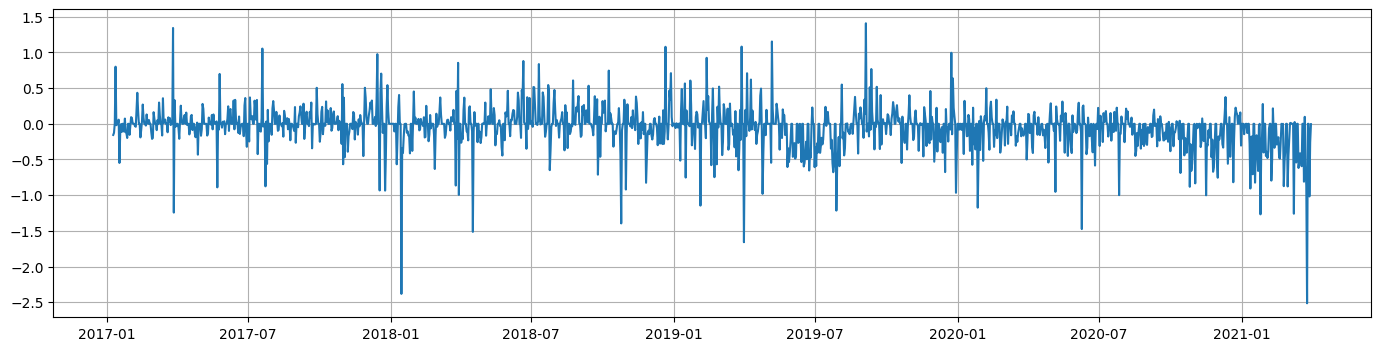

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(17, 4))
plt.plot(ts['Balance'])
plt.grid()
plt.show()

In [ ]:
plot_ts(ts['Balance'])

Loading BokehJS ...

# Попробуем авторегрессионные модели

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

исследуем ряд на стаионарность

In [ ]:
def adf_test(timeseries):
    # Выполняем тест Дики-Фуллера:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    print(dftest[1])
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

# применяем к ряду тест adf
adf_test(df['Balance'].dropna())

Results of Dickey-Fuller Test:
0.0009178315649531535
Test Statistic                   -4.114101
p-value                           0.000918
#Lags Used                       20.000000
Number of Observations Used    1522.000000
Critical Value (1%)              -3.434654
Critical Value (5%)              -2.863441
Critical Value (10%)             -2.567782
dtype: float64


видим, что p-value ниже порога, значит мы можем отвергнуть нулевую гипотезу, следовательно - по критерию Дики_фуллера нестационарность не выявлена

In [ ]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

kpss_test(df['Balance'].dropna())

Results of KPSS Test:
Test Statistic            3.132618
p-value                   0.010000
Lags Used                14.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


C:\Users\ICereal\AppData\Local\Temp\ipykernel_18020\698062597.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


По тесту KPSS ряд не стационарный

смотрим автокорреляции

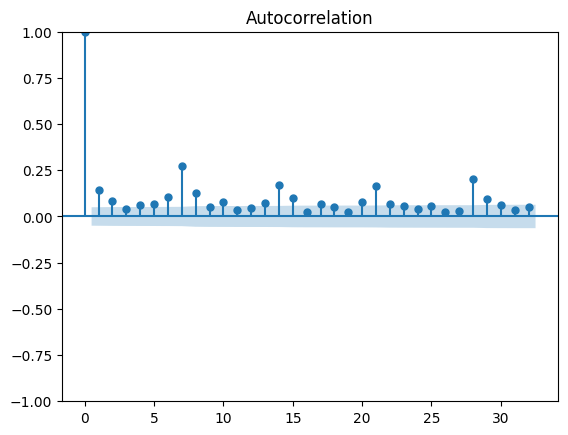

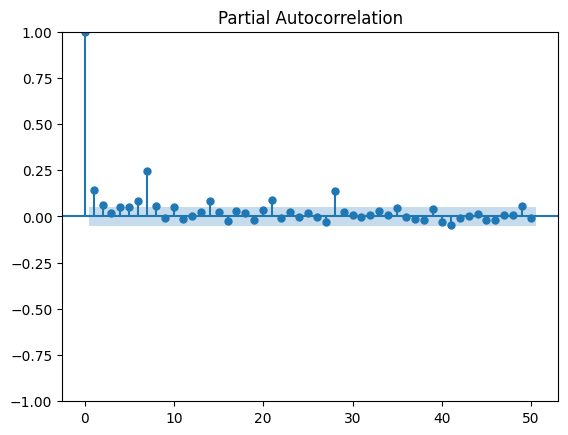

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts.dropna());
plot_pacf(ts, lags=50);

Есть слабо выраженная недельная сезонность(лаг 7 дней)

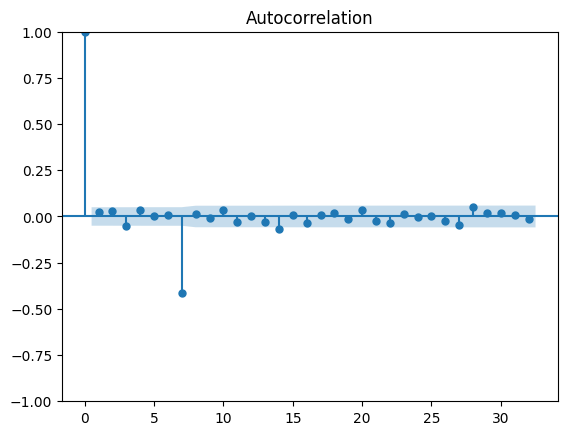

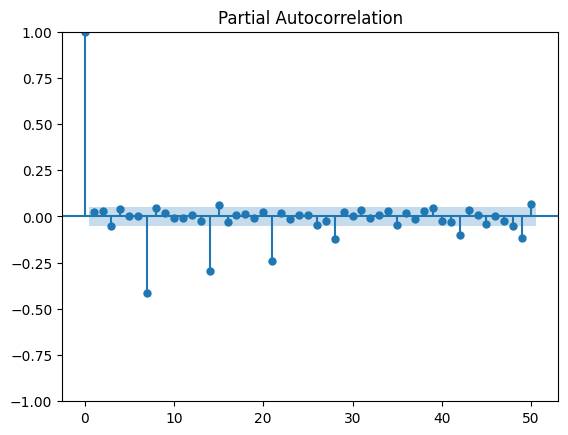

In [ ]:
plot_acf(ts.diff(7).dropna());
plot_pacf(ts.diff(7).dropna(), lags=50);

Дивверенцирование с лагом сезонности не помогает. Сезонность не слишком выражена.

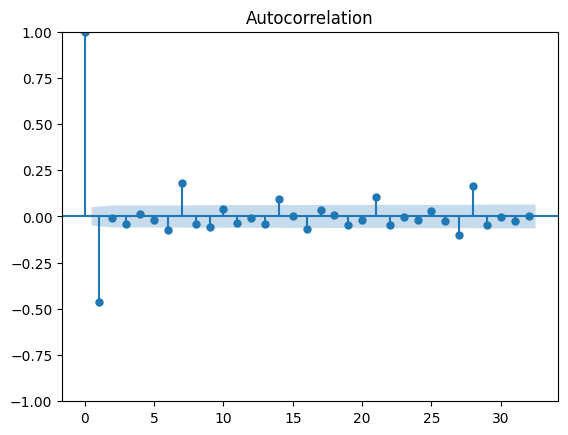

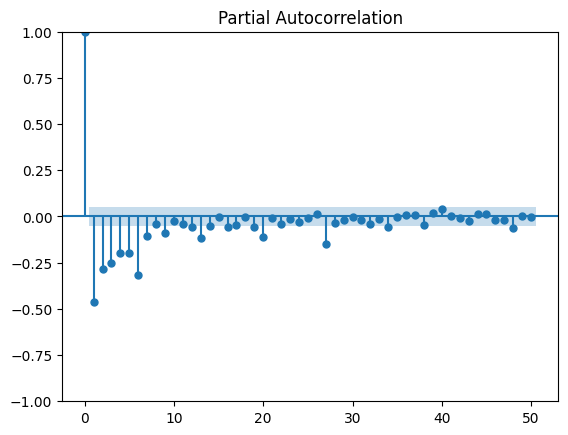

In [ ]:
plot_acf(ts.diff().dropna());
plot_pacf(ts.diff().dropna(), lags=50);

In [ ]:
kpss_test(df['Balance'].diff().dropna())

Results of KPSS Test:
Test Statistic             0.045695
p-value                    0.100000
Lags Used                126.000000
Critical Value (10%)       0.347000
Critical Value (5%)        0.463000
Critical Value (2.5%)      0.574000
Critical Value (1%)        0.739000
dtype: float64


C:\Users\ICereal\AppData\Local\Temp\ipykernel_18020\698062597.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpsstest = kpss(timeseries, regression="c", nlags="auto")


In [ ]:
adf_test(df['Balance'].diff().dropna())

Results of Dickey-Fuller Test:
2.3669747390451018e-27
Test Statistic                -1.476539e+01
p-value                        2.366975e-27
#Lags Used                     1.900000e+01
Number of Observations Used    1.522000e+03
Critical Value (1%)           -3.434654e+00
Critical Value (5%)           -2.863441e+00
Critical Value (10%)          -2.567782e+00
dtype: float64


Глазами кажется, что после дифференцирования с лагом 1 ряд становится более походящим для аврорегрессионной модели, выделяются лаги на которые есть корреляция. Также тесты говорят о том, что дифференцированный ряд стационарен. Так что оставим d = 1

q = 1 - кол-во значимых лагов в ACF\
p = 7 - кол-во значимых лагов в PACF

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

In [ ]:
pdq = (7, 1, 1)
seasonal_order=(0, 0, 0, 0) #без сезонности
model = ARIMA(ts, order=pdq).fit()

D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
D:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Смотрим коррелляции остатков

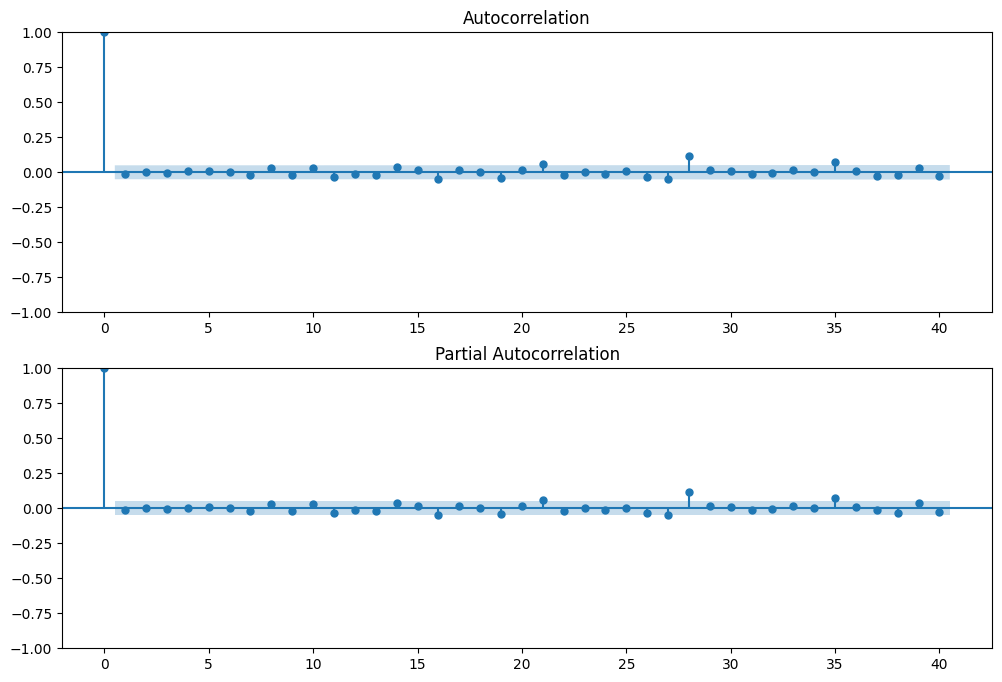

In [ ]:
resid = model.resid
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(resid.values.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(resid, lags=40, ax=ax2)

Остатки между собой не коррелируют, значит, все линейные зависимости учтены в модели.\
Вывод: использование авторегрессионных моделей возможно, будем сравнивать их с бустингами

# Модуль подбора гиперапарметров

In [ ]:
def custom_metric(y_true, y_pred, th = 3):
    series = y_true - y_pred
    n_days=len(series)
    intervals=np.linspace(th,1001)
    ths=list()
    for interval in intervals:
        k=0
        for d in range(n_days):
            if np.abs(series[d])<interval:
                k+=1
        ths.append(k/n_days*100)
    area=0
    delta = intervals[1] - intervals[0]
    for q in ths[1:]:
        area+=q*delta
    return area/(100*th)*100

our_metric = make_scorer(custom_metric)

In [ ]:
def find_params(curr_data, model):
    '''
    Модуль для подбора гиперпараметров
    Модели: LGBMRegressor/RandomForrestRegressor
    '''
    test_num = 90
    X = curr_data.drop('y', axis=1)
    y = curr_data['y']

    # Создаем список, где тренировочные индексы помечена -1, а валидационные 0
    split_index = [-1] * (X.shape[0] - test_num) + [0] * test_num

    pds = PredefinedSplit(test_fold = split_index)

    # описание сетки гиперпараметров
    if isinstance(model, RandomForestRegressor):
        param_grid = {
            'max_depth' : [2, 3, 5, 7, 9, 11, 13],
            'max_features' : [0.5, 0.6, 0.7, 0.8],
            'max_samples' : [None, 0.5, 0.6, 0.7, 0.8],
            'min_samples_split' : [2, 5, 7],
            'min_samples_leaf' : [1, 2, 4, 6],
            'n_estimators' : [150],
            'criterion' : ['absolute_error'],
            'random_state' : [4],
            'n_jobs' : [1]

        }
    elif isinstance(model, LGBMRegressor):
        param_grid = {
        'boosting_type': ['gbdt', 'dart', 'goss'],
        'num_leaves': sp_randint(20, 100),
        'learning_rate': np.linspace(0.01, 0.2, 10),
        'n_estimators': sp_randint(50, 500),
        'subsample_for_bin': sp_randint(20000, 50000),
        'min_child_samples': sp_randint(10, 50),
        'reg_alpha': np.linspace(0.0, 1.0, 10),
        'reg_lambda': np.linspace(0.0, 1.0, 10),
        'colsample_bytree': np.linspace(0.6, 1.0, 10),
        'subsample': np.linspace(0.6, 1.0, 10)
        }

    clf = RandomizedSearchCV(estimator = model,
                             cv=pds,
                             param_distributions=param_grid,
                             n_jobs=-1,
                             refit=False,
                             n_iter=100,
                             scoring=our_metric,
                             verbose=1)
    search = clf.fit(X, y)
    return search.best_params_


## Методы фильтрации

## Оберточный метод

Forward selection

In [ ]:
def best_feature(model, X, y, features_in, features_out):
    lag = 40
    X_train, y_train = X.iloc[:-lag] , y.iloc[:-lag]
    X_test, y_test = X.iloc[-lag:] , y.iloc[-lag:]
    model.fit(X_train[features_in], y_train)
    metric_baseline = mae(y_test, model.predict(X_test[features_in]))
    feature_to_add = None
    for name in features_out:
        model.fit(X_train[features_in + [name]], y_train)
        metric_new = mae(y_test, model.predict(X_test[features_in + [name]]))
        if metric_new > metric_baseline:
            feature_to_add = name
            metric_baseline = metric_new
    return feature_to_add

In [ ]:
def find_best_feature_space(model, X, y):
    features_importance = dict(zip(X.columns, model.feature_importances_))
    top_10_features = []
    for _ in range(10):
        max_key = max(features_importance, key=features_importance.get)
        features_importance[max_key] = .0
        top_10_features.append(max_key)
    features_to_select = list(set(X.columns) - set(top_10_features))
    while True:
        add = best_feature(model, X, y, top_10_features, features_to_select)
        if add == None:
            break
        else:
            top_10_features+= [add]
    return top_10_features

## Встроенный метод

Прогоняем линейную регрессию, выбираем топ самых влиятельных фичей

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

def linear_feature_selection(X, y):
    feature_standartization = [None if len(X[x_name].unique()) == 2 else x_name for x_name in X.columns]
    feature_standartization = list(filter(None , feature_standartization))
    ssc = StandardScaler()
    X[feature_standartization] = ssc.fit_transform(X[feature_standartization])
    regressor = Ridge()
    regressor.fit(X, y)
    feature_selection = dict(zip(X.columns, [abs(number) for number in regressor.coef_]))
    top_features = []
    for _ in range(15):
        max_key = max(feature_selection, key=feature_selection.get)
        feature_selection[max_key] = .0
        top_features.append(max_key)
    return  top_features


## Фильтрационный метод

Выбор по корреляции между фичей и таргетом

In [ ]:
def filter_feature_selection(X, y, n = 15):
    return list(X.corrwith(y).sort_values(ascending=False).head(n).index)

In [ ]:
ts

,Balance
Date,
2017-01-09,-0.155904
2017-01-10,-0.125572
2017-01-11,0.007767
2017-01-12,0.800391
2017-01-13,-0.019721
...,...
2021-03-27,0.000000
2021-03-28,0.000000
2021-03-29,-1.017679


# Сравниваем модели

In [ ]:
data = make_features(calendar_features=calendar_features,
                         time_series=ts,
                        usd_course_feature=usd_course).dropna()

In [ ]:
df = pd.read_csv('C:\\Users\\ICereal\\Downloads\\RTS.csv', sep=';',encoding='cp1251')
df1 = pd.read_csv('C:\\Users\\ICereal\\Downloads\\key_rate.csv')
df1 = df1.rename(columns={'date': 'Date'})
df = df.rename(columns={'TRADEDATE': 'Date'})
data1 =data.copy().reset_index()
data1 = data1.rename(columns={'index': 'Date'})

df['Date'] = df['Date'].astype('datetime64[ns]')
data1 = pd.merge(data1, df[['Date','CLOSE']], on='Date', how='left')
df1['Date'] = df1['Date'].astype('datetime64[ns]')
data1= pd.merge(data1, df1, on='Date', how='left')
data1 = data1.rename(columns={'CLOSE':'RTS'})
data1= data1.fillna(method='ffill')

data1 = data1.drop(columns=['Date'])
data['RTS'] = data1['RTS'].tolist()
data['rate'] = data1['rate'].tolist()
data

,y,lag_1,lag_2,lag_3,lag_4,lag_month_1,lag_month0,lag_month1,rolling_mean,rolling_median,...,июнь,июль,август,сентябрь,октябрь,ноябрь,декабрь,usd_rub_course,RTS,rate
2017-02-10,0.183553,0.434681,0.196944,-0.041289,-0.032282,-0.155904,-0.125572,0.007767,0.080692,0.000000,...,0,0,0,0,0,0,0,59.173100,1642.05,10.0
2017-02-11,0.000000,0.183553,0.434681,0.196944,-0.041289,-0.125572,0.007767,0.800391,0.105944,0.000000,...,0,0,0,0,0,0,0,58.961201,1642.05,10.0
2017-02-12,0.000000,0.000000,0.183553,0.434681,0.196944,0.007767,0.800391,-0.019721,0.105944,0.000000,...,0,0,0,0,0,0,0,0.000000,1642.05,10.0
2017-02-13,-0.190470,0.000000,0.000000,0.183553,0.434681,0.800391,-0.019721,0.000000,0.105944,0.000000,...,0,0,0,0,0,0,0,0.000000,1654.68,10.0
2017-02-14,-0.086178,-0.190470,0.000000,0.000000,0.183553,-0.019721,0.000000,0.000000,0.083345,0.000000,...,0,0,0,0,0,0,0,58.222301,1655.81,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-27,0.000000,-2.514887,-0.869810,-0.587778,0.098041,-0.355811,0.000000,0.000000,-0.669331,-0.587778,...,0,0,0,0,0,0,0,76.117104,2626.09,4.5
2021-03-28,0.000000,0.000000,-2.514887,-0.869810,-0.587778,0.000000,0.000000,-0.877702,-0.669331,-0.587778,...,0,0,0,0,0,0,0,0.000000,2626.09,4.5
2021-03-29,-1.017679,0.000000,0.000000,-2.514887,-0.869810,0.000000,0.000000,-0.877702,-0.669331,-0.587778,...,0,0,0,0,0,0,0,0.000000,2659.22,4.5
2021-03-30,-0.259687,-1.017679,0.000000,0.000000,-2.514887,0.000000,0.000000,-0.877702,-0.698873,-0.587778,...,0,0,0,0,0,0,0,75.661102,2645.04,4.5


In [ ]:
split_idx = int(len(data) * 0.7)
ts_train, ts_test = data[:split_idx], data[split_idx:]

NameError: name 'data' is not defined

In [ ]:
best_features = filter_feature_selection(ts_train.drop('y', axis=1), data['y'], n = 20)

In [ ]:
best_features

['rolling_median_weekday',
 'rolling_mean_weekday',
 'rolling_median',
 'rolling_min_weekday',
 'usd_rub_course',
 'rolling_max_weekday',
 'rolling_mean',
 'чт',
 'lag_1',
 'rolling_min',
 'lag_2',
 'mean_month',
 'сентябрь',
 'lag_month1',
 'max_month',
 'rate',
 'rolling_max',
 'min_month',
 'lag_month0',
 'пт']

In [ ]:
change_name = {'чт':'cht', 'пт':'fr'}

In [ ]:
for key, item in change_name.items():
    best_features.remove(key)
    best_features += [item]

In [ ]:
best_features

['rolling_median_weekday',
 'rolling_mean_weekday',
 'rolling_median',
 'rolling_min_weekday',
 'usd_rub_course',
 'rolling_max_weekday',
 'rolling_mean',
 'lag_1',
 'rolling_min',
 'lag_2',
 'mean_month',
 'сентябрь',
 'lag_month1',
 'max_month',
 'rate',
 'rolling_max',
 'min_month',
 'lag_month0',
 'cht',
 'fr']

In [ ]:
ts_train = ts_train.rename(columns = change_name)
ts_test = ts_test.rename(columns = change_name)

In [ ]:
forrest_params = find_params(ts_train[best_features + ['y']], RandomForestRegressor())

RF_model = RandomForestRegressor(**forrest_params)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


In [ ]:
RF_model.fit(ts_train[best_features], ts_train['y'])
rf_pred = RF_model.predict(ts_test[best_features])

In [ ]:
lgbm_params = find_params(ts_train[best_features + ['y']], LGBMRegressor())
LGBM_model = LGBMRegressor(**forrest_params)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


In [ ]:
LGBM_model.fit(ts_train[best_features], ts_train['y'])
lgbm_pred = LGBM_model.predict(ts_test[best_features])

In [ ]:
from pmdarima import auto_arima
# на вход подается ряд со всеми преобразованиями кроме дифференцирования, границы поиска параметров p, q, P, Q,
# периодом сезонности m, параметрами дифференцирования d, D
arima = auto_arima(
     ts_train['y'], start_p=1, start_q=1,
     max_p=7, max_q=7,seasonal=False,
     trace=True,
     error_action='ignore',
     suppress_warnings=True,
     stepwise=True
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=356.885, Time=0.56 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=990.595, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=710.598, Time=0.19 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=357.888, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=988.595, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=361.628, Time=0.94 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=357.080, Time=1.30 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=649.606, Time=0.31 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=360.782, Time=2.14 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=354.933, Time=0.36 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=355.928, Time=0.23 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=708.598, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=356.216, Time=0.77 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=359.669, 

In [ ]:
arima_pred = arima.predict(len(ts_test))

In [ ]:
def confidence_bands(series, th):
    n_days=len(series)
    intervals=np.linspace(0,th,1001)
    delta = intervals[1] - intervals[0]
    ths=list()
    for interval in intervals:
        k=0
        for d in range(n_days):
            if np.abs(series[d])<interval:
                k+=1
        ths.append(k/n_days*100)
    area=0
    for q in ths[1:]:
        area+=q*delta
    return [intervals,ths],area/(100*th)*100

In [ ]:
model_predictions ={'ARIMA': arima_pred, 'LGBM': lgbm_pred, 'RF': rf_pred}

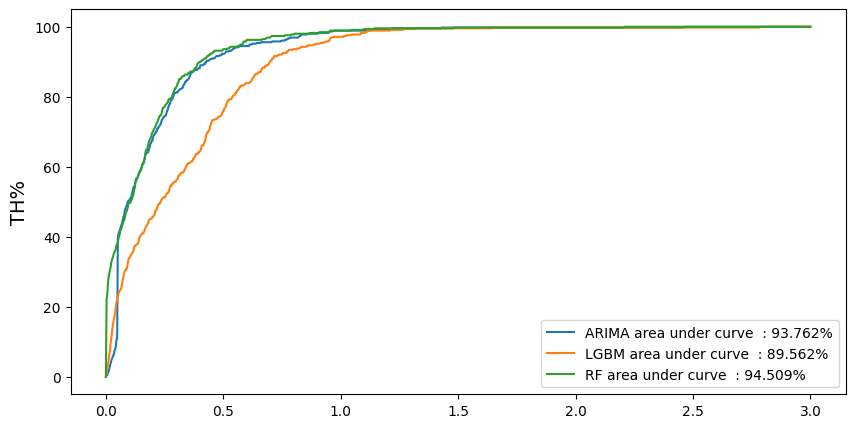

In [ ]:
fig, axes = plt.subplots(figsize=(10,5))
for name, preds in model_predictions.items():
    coordinates,area=confidence_bands(ts_test['y']-preds, th = 3)
    axes.plot(coordinates[0],coordinates[1],label=name+' area under curve  : '+str(round(area,3))+'%')
    axes.set_ylabel('TH%',fontsize=14)
    axes.legend()
plt.show()


Посмотрим предикт

In [ ]:
lgbm_pred = pd.Series(lgbm_pred, index = ts_test.index)
rf_pred = pd.Series(rf_pred, index = ts_test.index)
arima_pred = pd.Series(arima_pred, index = ts_test.index)

In [ ]:
plot_ts(ts_test['y'], lgbm_pred, title = 'LGBM')

Loading BokehJS ...

In [ ]:
plot_ts(ts_test['y'], arima_pred, title = 'ARIMA')

Loading BokehJS ...

In [ ]:
plot_ts(ts_test['y'], rf_pred, title = 'RandomForrest')

Loading BokehJS ...

Лучшая модель в ходе тестов - RF


Попробуем найти время, через какой период понадобится refit модели:

Берем различные выборки на обучение. Для каждой считаем как качество ухудшается по мере удаления по времени от обучающей выборки. Если увидим, что в какой-то момент качество начинает проседать и этот паттерн повториться и на других обуч выборках, то рефит нужно делать раньше

In [ ]:
best_features = filter_feature_selection(ts_train.drop('y', axis=1), data['y'], n = 20)

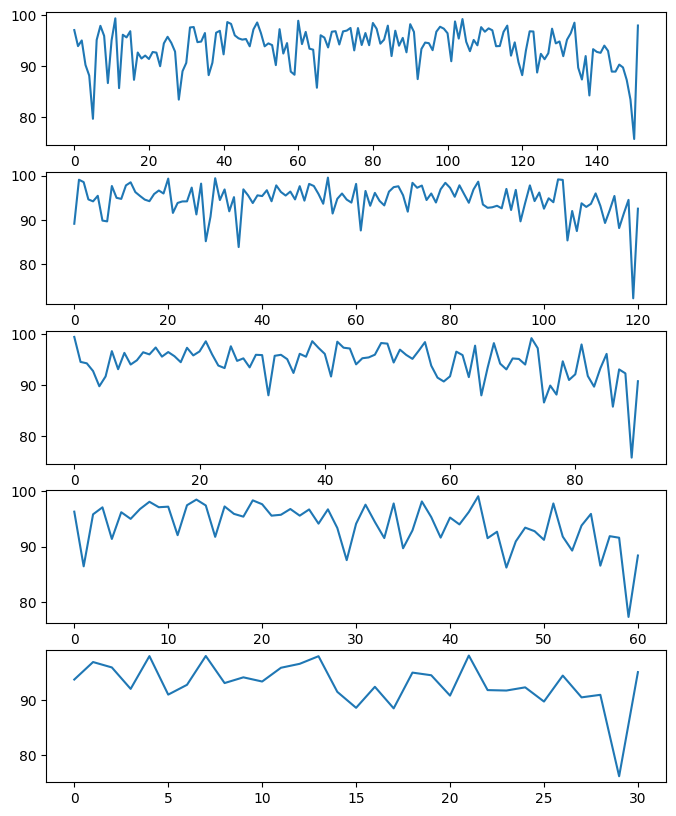

In [ ]:
model = RandomForestRegressor(criterion='absolute_error', max_depth=3, max_features=0.6,
                      max_samples=0.8, min_samples_leaf=2, min_samples_split=5,
                      n_estimators=150, n_jobs=1, random_state=4)

step = 5
metrics = []
for frac_test in np.arange(0.5,1, 0.1):
  split_idx = int(len(data) * frac_test)
  ts_train, ts_test = data[:split_idx], data[split_idx:]
  model.fit(ts_train[best_features], ts_train['y'])
  preds = model.predict(ts_test[best_features])
  preds = pd.Series(preds, index = ts_test.index)
  metric = [confidence_bands(ts_test.iloc[i:i+step]['y']-preds.iloc[i: i+step], th = 3)[1]\
            for i in range(0, len(ts_test), step)]
  metrics.append(metric)

fig, axes = plt.subplots(5, 1, figsize=(8, 10))
for i in range(5):
  axes[i].plot(metrics[i])
plt.show()

У нас нет просадки видимой качества по мере отдаления от обучающей выборки. Но, поскольку, хуже от refit модели не будет, будем каждые 14 дней переобучать модель

## Метрика стабильности

В качестве метрики стабильности между i и j набором фичей будет рассматриваться мера схожести как евклидово расстояние есть (есть фича- (1 - 1), фича пропала - (1 - 0), за все итеррации будет браться среднее)

In [ ]:
def euclidean_distance(feature_i, feature_j):
    n = 0
    for feature in feature_j:
        if feature in feature_i:
            n+=1
    return np.sqrt(n)

## Прогон модели

In [ ]:
def find_params(curr_data):
    '''
    Модуль для подбора гиперпараметров
    В качестве модели используем случайный лес
    '''
    test_num = 90
    X = curr_data.drop('y', axis=1)
    y = curr_data['y']
    model = RandomForestRegressor()

    # Создаем список, где тренировочные индексы помечена -1, а валидационные 0
    split_index = [-1] * (X.shape[0] - test_num) + [0] * test_num

    pds = PredefinedSplit(test_fold = split_index)

    # описание сетки гиперпараметров
    param_grid = {
        'max_depth' : [2, 3, 5, 7, 9, 11, 13],
        'max_features' : [0.5, 0.6, 0.7, 0.8],
        'max_samples' : [None, 0.5, 0.6, 0.7, 0.8],
        'min_samples_split' : [2, 5, 7],
        'min_samples_leaf' : [1, 2, 4, 6],
        'n_estimators' : [150],
        'criterion' : ['absolute_error'],
        'random_state' : [4],
        'n_jobs' : [1]

    }

    clf = RandomizedSearchCV(estimator = model,
                             cv=pds,
                             param_distributions=param_grid,
                             n_jobs=-1,
                             refit=False,
                             n_iter=30,
                             scoring=our_metric,
                             verbose=0)
    search = clf.fit(X, y)
    return search.best_params_

In [ ]:
from datetime import timedelta
from tqdm import tqdm

param_resel_freq = 14
refit_freq = 14
last_refit_date = pd.to_datetime('2000-01-01')
last_param_resel_date = pd.to_datetime('2000-01-01')
preds = []


daterange = pd.date_range('2020-01-01', '2020-01-20')
for curr_date in tqdm(daterange):
    detector = AnomalyDetector(backward_window_size=30, forward_window_size=14,
                               threshold=3, drift=1.1)

    # если за последнюю неделю 6 или более аномалий, то разладка
    anomalies = detector.detect(ts.loc[:curr_date, 'Balance'])
    if anomalies.iloc[-7:].sum() >= 6:
        print(f'Обнаружена разладка:')
        plt.figure(figsize=(14, 4))
        plt.plot(ts.loc[:curr_date, 'Balance'])
        tmp_anoms = anomalies.replace(0, np.nan).dropna()
        plt.scatter(tmp_anoms.index, ts.loc[tmp_anoms.index, 'Balance'],
                    color='red')
        plt.grid()
        plt.show()

    data = make_features(calendar_features=calendar_features,
                         time_series=ts.loc[:curr_date+timedelta(days=1),
                                            'Balance'],
                        usd_course_feature=usd_course).dropna()
    #break
    if (curr_date - last_param_resel_date).days >= param_resel_freq or \
            anomalies.iloc[-7:].sum() >= 6:
        params = find_params(data.loc[:curr_date])
        last_param_resel_date = curr_date

    if (curr_date - last_refit_date).days >= refit_freq or \
            anomalies.iloc[-7:].sum() >= 6:
        model = RandomForestRegressor(**params)
        model.fit(data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])
        last_refit_date = curr_date
    preds.append(model.predict(data.iloc[-1:].drop('y', axis=1)))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:53<00:00,  8.65s/it]


In [ ]:
preds = np.asarray([i[0] for i in preds])

In [ ]:
preds

array([ 0.00322523, -0.1644026 , -0.01017845, -0.00308352, -0.12969317,
        0.06308782, -0.03463139,  0.06780116, -0.07653059, -0.00471786,
       -0.00182833, -0.14340163,  0.03629958, -0.04002978,  0.01242516,
       -0.04111052, -0.00448317, -0.00150225, -0.15695352, -0.08340534])

In [ ]:
y_true = ts.loc[daterange, 'Balance'].values

In [ ]:
mae(y_true, preds)

0.15109933057367303

# Фильтрационные методы:

In [ ]:
find_best_feature_space(model, data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])

['rolling_median_weekday',
 'lag_1',
 'rolling_mean_weekday',
 'rolling_min_weekday',
 'rolling_mean',
 'rolling_max_weekday',
 'rolling_min',
 'lag_month_1',
 'rolling_std_weekday',
 'lag_month1',
 'чт',
 'чт',
 'median_month']

In [ ]:
filter_feature_selection(data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])

['rolling_median_weekday',
 'rolling_mean_weekday',
 'rolling_median',
 'rolling_min_weekday',
 'usd_rub_course',
 'rolling_mean',
 'rolling_max_weekday',
 'чт',
 'mean_month',
 'lag_1',
 'rolling_min',
 'lag_2',
 'сентябрь',
 'min_month',
 'max_month']

In [ ]:
linear_feature_selection(data.loc[:curr_date].drop('y', axis=1), data.loc[:curr_date, 'y'])

['rolling_std',
 'rolling_min',
 'пн',
 'чт',
 'выходной',
 'налоговый_день',
 'rolling_max',
 'rolling_mean',
 'сб',
 'rolling_max_weekday',
 'rolling_std_weekday',
 'rolling_min_weekday',
 'вс',
 'lag_3',
 'usd_rub_course']

# Бизнес-процесс:

Посчитаем доход от размещения на рынке деривативов за период '2020-01-01' - '2020-01-20':
За этот период процентная ставка равнялась 6.25%


In [ ]:
key_rates = np.ones(y_true.shape)*6.25/100
key_rates

array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.0625, 0.0625, 0.0625, 0.0625])

In [ ]:
def fin_effect(y_preds, y_true, key_rates):
    profits = []
    for i in range(len(y_preds)):
        if preds[i] > 0:
            profit = (key_rates[i] + 0.5/100) * preds[i]
            if y_true[i]> y_preds[i]:
                profit += (y_true[i]- y_preds[i]) * (key_rates[i] + 0.9/100)
            else:
                profit -= (y_true[i]- y_preds[i]) * (key_rates[i] + 1/100)
        else:
            profit = 0
        profits.append(profit)
    return sum(profits)

Получим доход за размещение на рынке деривативов за период '2020-01-01' - '2020-01-20':

In [ ]:
fin_effect(preds, y_true, key_rates)

0.05153299042673326